[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kyo-takano/chinchilla/blob/master/examples/efficientcube.ipynb)
[![GitHub Repository](https://img.shields.io/badge/-chinchilla-2dba4e?logo=github)](https://github.com/kyo-takano/chinchilla)

> This notebook demonstrates how to use the [`chinchilla`](https://github.com/kyo-takano/chinchilla) library to estimate scaling laws & train compute-optimal neural networks within a compute budget.
>
> Running the entire notebook with the default setting would take ~9 hours on a consumer-grade GPU & 4+ CPU cores.

---

# **Training Compute-Optimal Rubik's Cube Solvers**

`chinchilla` is a library that helps **find the optimal allocation of compute between model size** and **training data to maximize performance under a budget**.

To shocase `chinchilla`'s capabilities, we will use a method called **EfficientCube** to solve the Rubik's Cube as an example.
It was chosen for the following reasons:

- It can be easily & quickly trained through a simple and stable self-supervised learning task (a discrete diffusion process).
- It does ***not*** require external data, as the environment itself generates the necessary information.
- It exhibits model & data scalability similar to large language models (LLMs).



For more background about the task & the method, see [Self-Supervision is All You Need for Solving Rubik's Cube (Takano, 2023)](https://openreview.net/forum?id=bnBeNFB27b.).

<div>
<img width="480" src="https://raw.githubusercontent.com/kyo-takano/chinchilla/master/docs/imgs/Figure-1.gif" alt="Overview of the EfficientCube method">
</div>

## Install `chinchilla`

In [ ]:
# !pip install -q chinchilla
!git clone https://github.com/kyo-takano/chinchilla.git
%cd chinchilla
!pip install -e .

Cloning into 'chinchilla'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 43 (delta 10), reused 41 (delta 9), pack-reused 0
Receiving objects: 100% (43/43), 3.60 MiB | 9.13 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/content/chinchilla
Obtaining file:///content/chinchilla
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 10.0 MB/s eta 0:00:00
  Building editable for chinchilla (pyproject.toml) ... done
  Created wheel for chinchilla: filename=chinchilla-0.1.1-0.editable-py3-none-any.whl size=13271 sha256=e3213bb2dd11df11dd5a0c73e0aa3b3013ce70468305013a4b7a1bdfd0e05317
  Stored in d

## Environment Setup

### Libraries

Imports the necessary libraries.

In [ ]:
# core
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

# misc.
import gc
from tqdm import trange
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device, os.cpu_count()

(device(type='cuda'), 8)

### Model architecture

Next, define the NN architecture we'll be using.

The default configuration consists of an embedding layer, multiple linear layers with ReLU & BatchNorm, and a classification layer.

The `reset_parameters` method initializes the weights.

In [ ]:
# From https://github.com/kyo-takano/alphacube/blob/main/alphacube/model.py


class LinearBlock(nn.Module):
    def __init__(self, input_prev, hidden_size, bias=True):
        super(LinearBlock, self).__init__()
        self.fc = nn.Linear(input_prev, hidden_size, bias=bias)
        self.bn = nn.BatchNorm1d(hidden_size)

    def forward(self, inputs):
        x = inputs
        x = self.fc(x)
        x = F.relu(x)
        x = self.bn(x)
        return x


class Net(nn.Module):
    def __init__(
        self, hidden_size=4096, num_hidden_layers=8, input_dim=324, output_dim=18
    ):
        super(Net, self).__init__()
        self.embedding = nn.Linear(input_dim, hidden_size, bias=False)
        self.layers = nn.ModuleList(
            [
                LinearBlock(hidden_size, hidden_size, bias=True)
                for i in range(num_hidden_layers)
            ]
        )
        self.head = nn.Linear(hidden_size, output_dim, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        """Basic initialization"""
        nn.init.normal_(
            self.embedding.weight, std=np.sqrt(1 / 54)
        )  # There'll be 54 ones in a sample
        for layer in self.layers:
            nn.init.kaiming_normal_(layer.fc.weight)
            nn.init.zeros_(layer.fc.bias)

    def forward(self, inputs):
        x = F.one_hot(inputs, 6).reshape(-1, 324).float()
        x = self.embedding(x)
        for layer in self.layers:
            x = layer(x)
        logits = self.head(x)
        return logits

### Data

As the GIF animation shows, the training data can be generated simply by sequentially applying random moves to the solved Rubik's Cube state.
We'll use my `alphacube` Python package to generate this training data. We'll call `alphacube.env.get_dataloader(batch_size)` to get a PyTorch DataLoader.

In [ ]:
!pip install -q alphacube
import alphacube

## `chinchilla`


### Model search space

To get a configuration to initialize `Net` based on $N$ (whether randomly sampled or suggested as compute-optimal), you need to have the following things defined:

1.  A function that arithmetically estimates $N$ from a model configuration
2.  The grid of parameters representing combinations of model configurations to search through

In [ ]:
# 1.
def estimate_model_size(hidden_size, num_hidden_layers, input_dim=324, output_dim=18):
    """You may narrow down the combinatorial space like this"""
    if not 2**6 <= hidden_size / num_hidden_layers < 2**10:
        return float("inf")
    """Assumption: the same hidden_size for all hidden layers"""
    embedding = input_dim * hidden_size
    layers = num_hidden_layers * (
        (hidden_size + 1) * hidden_size  # linear
        + (hidden_size * 2)  # batchnorm
    )
    head = hidden_size * output_dim
    return sum([embedding, layers, head])


# 2.
model_search_config = dict(
    size_estimator=estimate_model_size,
    hyperparam_grid=dict(
        hidden_size=list(range(64, 65536 + 1, 64)), num_hidden_layers=list(range(1, 64))
    ),
)

Let's test the estimator really quick.

<div>
(In practice, the estimates do not need to be this precise)
</div>

In [ ]:
import itertools

for hidden_size, layers in itertools.product(64 * np.arange(1, 8 + 1), range(1, 8 + 1)):
    model = Net(hidden_size, layers)
    N_true = sum(p.numel() for p in model.parameters() if p.requires_grad)
    N_pred = estimate_model_size(hidden_size, layers)
    assert N_pred == N_true or not np.isfinite(N_pred), (N_pred, N_true)

### Scaling-law search space
You can then construct a `Chinchilla` object. In doing so, you have to specify a couple more dictionaries.

- **`seed_ranges`** specifies the regime of seed model allocations as a starter to fit the loss predictor.
- **`param_grid`** specifies a set of initial points to fit the parametric loss predictor with the [L-BFGS algorithm](https://en.wikipedia.org/wiki/Limited-memory_BFGS)

In [ ]:
from chinchilla import Chinchilla


project_dir = "efficientcube"

cc = Chinchilla(
    project_dir,
    # Seed models: 10 ^ 14.5~15.5 FLOPS, 64 <= N/D <= 256
    seed_ranges=dict(C=(10**14.5, 10**15.5), N_to_D=(64, 256)),
    param_grid=dict(
        E=np.linspace(1.0, 1.5, 6),
        a=np.linspace(2, 7, 6),  # Log form (scale doesn't really matter)
        b=np.linspace(2, 7, 6),
        alpha=np.linspace(0.1, 0.5, 5),
        beta=np.linspace(0.1, 0.5, 5),
    ),
    model_search_config=model_search_config,
    scaling_factor=2.0,  # Double the compute budget each step (after seed models)
)

[07:36:47] INFO     Creating a directory: efficientcube                                                 ]8;id=119519;file:///content/chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=688654;file:///content/chinchilla/chinchilla/core.py#148\148]8;;\

[07:36:47] INFO     Initializing a database to be saved to: efficientcube/df.csv                     ]8;id=409220;file:///content/chinchilla/chinchilla/database.py\database.py]8;;\:]8;id=958490;file:///content/chinchilla/chinchilla/database.py#51\51]8;;\

[07:36:47] INFO     Chinchilla instance created successfully.                                           ]8;id=457080;file:///content/chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=942977;file:///content/chinchilla/chinchilla/core.py#156\156]8;;\

To make sure `seed_ranges` and `model_search_config` are okay, you can use the simulation utility *without scaling steps* to visualize the distribution of random samples.

[07:36:47] INFO     Initializing an in-memory database for Simulator.                                ]8;id=372114;file:///content/chinchilla/chinchilla/database.py\database.py]8;;\:]8;id=757256;file:///content/chinchilla/chinchilla/database.py#51\51]8;;\

           INFO     Starting a simulation                                                          ]8;id=728404;file:///content/chinchilla/chinchilla/simulator.py\simulator.py]8;;\:]8;id=232000;file:///content/chinchilla/chinchilla/simulator.py#116\116]8;;\

Output()

[07:37:10] WARNING  The scaling law parameters has not been estimated. Plotting only raw data      ]8;id=6633;file:///content/chinchilla/chinchilla/visualizer.py\visualizer.py]8;;\:]8;id=541516;file:///content/chinchilla/chinchilla/visualizer.py#82\82]8;;\
                    points.                                                                                        

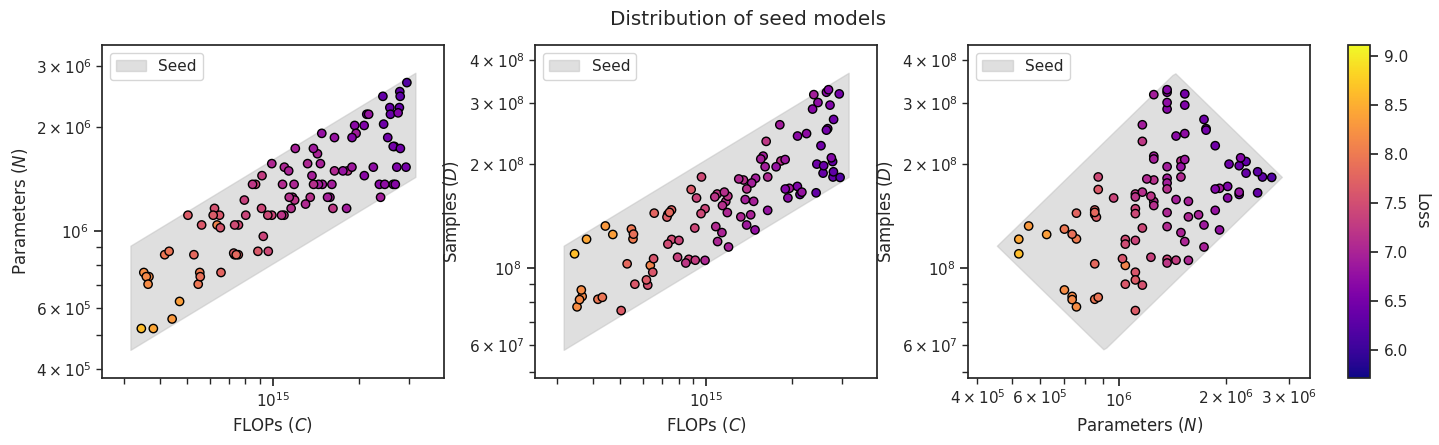

[07:37:12] INFO     Image saved to efficientcube/simulation--raw_data_points.png                  ]8;id=213427;file:///content/chinchilla/chinchilla/visualizer.py\visualizer.py]8;;\:]8;id=626688;file:///content/chinchilla/chinchilla/visualizer.py#153\153]8;;\

In [ ]:
cc.simulate(100, 0)  # (seeding, scaling)

We can see that they are almost evenly distributed.

### Evaluator

As the most important part, you need to have a function or something equivalent to evaluate the allocation $(N,\ D)$.
The most basic way would be just to measure with the loss function.


Alternatively, you may evaluate each trained model on downstream task(s), like [Google did with PaLM 2](https://arxiv.org/abs/2305.10403).
Just make sure that higher performance is signalled as lower values.

In [ ]:
ctx = torch.cuda.amp.autocast(
    dtype=torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
)
loss_fn = nn.CrossEntropyLoss()


def evaluate_fn(model, N, D, batch_size=4096, lr=1e-4, num_eval_steps=100):
    """Train a model and then evaluate the perplexity on the equivalent of 4096 solutions *per batch*."""
    num_iters = round(D / (batch_size * 20))
    dl = alphacube.env.get_dataloader(batch_size)

    # Set up model, loss function, & optimizer
    model.to(device)
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

    # Train
    h = []
    for i, (batch_x, batch_y) in zip(trange(num_iters), dl):
        batch_x, batch_y = batch_x.to(device), batch_y.reshape(-1).to(device)
        with ctx:
            pred_y = model(batch_x)
            loss = loss_fn(pred_y, batch_y)
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        assert not torch.isnan(loss)
        h.append(loss.item())

    # Evaluate (full-precision)
    model.eval()
    loss_eval = 0.0
    for i, (batch_x, batch_y) in zip(range(num_eval_steps), dl):
        batch_x, batch_y = batch_x.to(device), batch_y.reshape(-1).to(device)
        with torch.no_grad():
            pred_y = model(batch_x)
            loss = loss_fn(pred_y, batch_y)
        loss_eval += loss.item() / num_eval_steps
        assert not np.isnan(loss_eval)

    # Visualize the training result
    plt.figure(figsize=(4.8, 3.2))
    plt.semilogx(h, label="train")
    plt.axhline(loss_eval, ls=":", color="black", label=f"eval {loss_eval:.4f}")
    plt.legend()
    plt.xlabel("steps")
    plt.ylabel("log loss")
    plt.title(f"{N=:.2e}, {D=:.2e}")
    plt.show()

    return loss_eval

> For simplicity, we omit hyperparameter optimization, lr scheduling, etc.

## Estimating the Scaling Law

Now, we first train 100 models aournd a PetaFLOPs,
and then double the compute for 5 consecutive steps.

⠋ Fitting scaling law ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 0:01:18 / 0:00:01

[14:47:46] INFO     Goodness-of-fit to Exp(λ=69.77): KS=0.2, p=0.8088043692810752                 ]8;id=119237;file:///content/chinchilla/chinchilla/visualizer.py\visualizer.py]8;;\:]8;id=377648;file:///content/chinchilla/chinchilla/visualizer.py#211\211]8;;\

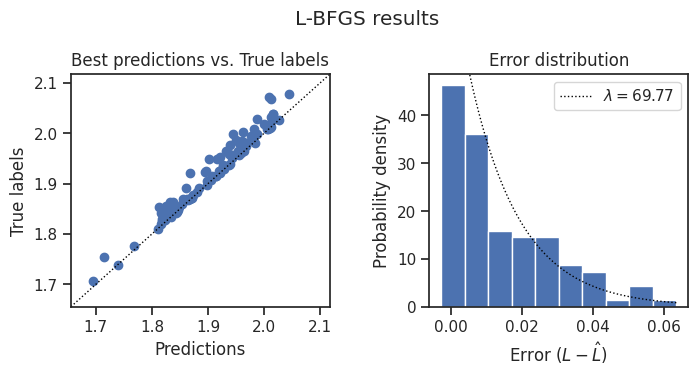

[14:47:47] INFO     Loss predictor:                                                                     ]8;id=931978;file:///content/chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=967090;file:///content/chinchilla/chinchilla/core.py#369\369]8;;\
                                                                                                                   
                      L(N, D) = 1.620 + 1097. / (N ^ 0.6480) + 8.400e+04 / (D ^ 0.7048)                            
                                                                                                                   

           INFO     [105th] 9.54e+16 FLOPs => 1.05e+07 params * 1.52e+09 samples                        ]8;id=362052;file:///content/chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=842315;file:///content/chinchilla/chinchilla/core.py#445\445]8;;\

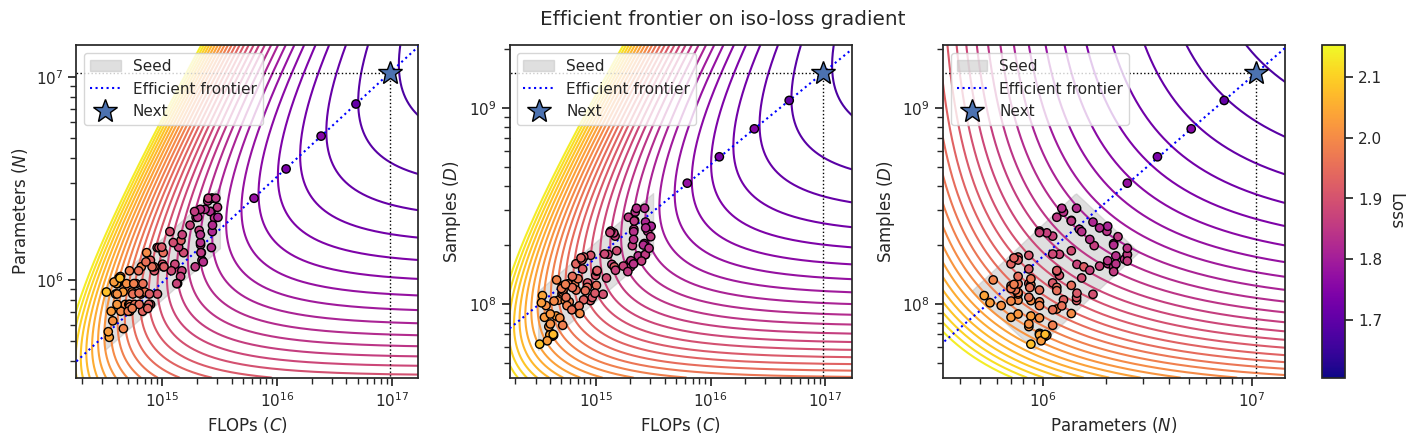

[14:47:49] INFO     Image saved to efficientcube/parametric_fit.png                               ]8;id=44491;file:///content/chinchilla/chinchilla/visualizer.py\visualizer.py]8;;\:]8;id=381929;file:///content/chinchilla/chinchilla/visualizer.py#153\153]8;;\

model_config={'hidden_size': 960, 'num_hidden_layers': 11}


100%|██████████| 18495/18495 [1:52:00<00:00,  2.75it/s]


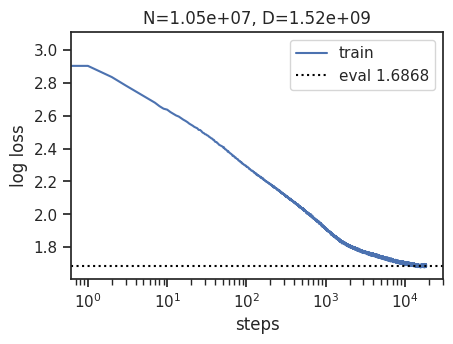

In [ ]:
num_seeding_steps = 100
num_scaling_steps = 5

for i in range(len(cc.database.df), num_seeding_steps + num_scaling_steps):
    # Sample a new model & update the scaling estimate with more than 100 runs
    (N, D), model_config = cc.step(num_seeding_steps=num_seeding_steps)
    """ Internally, something like this is happening:
    >>> if len(cc.database.df) < num_seeding_steps:
    ...     (N, D), model_config = cc.seed()
    ... else:
    ...     cc.fit()
    ...     (N, D), model_config = cc.scale()
    """
    print(f"{model_config=}")

    # Build the model
    model = Net(**model_config)

    # Evaluate the (N, D) scenario by actually training the model
    loss = evaluate_fn(model, N, D)

    # Record the result
    cc.append(N=N, D=D, loss=loss)

    # Clear the cache
    if i + 1 < num_seeding_steps + num_scaling_steps:
        del model
        gc.collect()
        torch.cuda.empty_cache()

All results:

In [ ]:
cc.database.df

,C,N,D,loss
0,1527497216815507,1365504,186438758,1.891363
1,325816219317013,874368,62105090,2.078798
2,406863999334396,961408,70532663,2.033035
3,650143208680881,854784,126765594,1.938449
4,457963023839918,577152,132247953,1.988139
...,...,...,...,...
100,6275748577285946,2531520,413173941,1.775641
101,11931955671132283,3528448,563607365,1.739272
102,24058263890479730,5120128,783127033,1.753341
103,48373234575728397,7368192,1094190510,1.707429


We've now trained a **100 PetaFLOPs** model.

<div>
(Only logs and images for the final model are displayed due to the <code>rich</code> library)
</div>

## Final estimate & Observations

Let's fit the loss predictor one last time, and also see the optimal allocation for a **1 ExaFLOP** model (which is totally doable within another 3 hours).

⠏ Fitting scaling law ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 0:01:17 / 0:00:01

[16:42:22] INFO     Goodness-of-fit to Exp(λ=69.57): KS=0.2, p=0.8088043692810752                 ]8;id=770966;file:///content/chinchilla/chinchilla/visualizer.py\visualizer.py]8;;\:]8;id=812310;file:///content/chinchilla/chinchilla/visualizer.py#211\211]8;;\

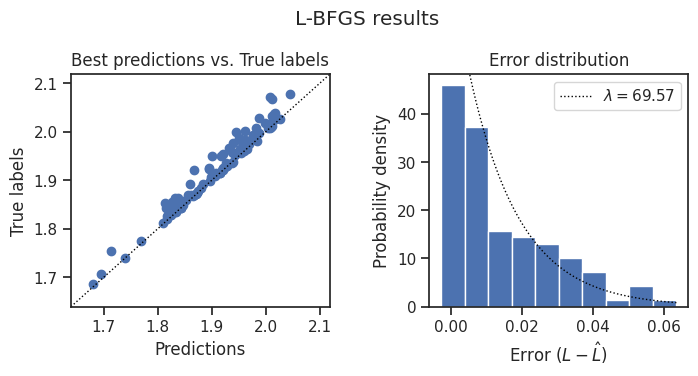

           INFO     Loss predictor:                                                                     ]8;id=95933;file:///content/chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=32747;file:///content/chinchilla/chinchilla/core.py#369\369]8;;\
                                                                                                                   
                      L(N, D) = 1.620 + 1117. / (N ^ 0.6492) + 9.270e+04 / (D ^ 0.7105)                            
                                                                                                                   

[16:42:23] INFO     [106th] 9.99e+17 FLOPs => 3.62e+07 params * 4.59e+09 samples                        ]8;id=915189;file:///content/chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=796893;file:///content/chinchilla/chinchilla/core.py#445\445]8;;\

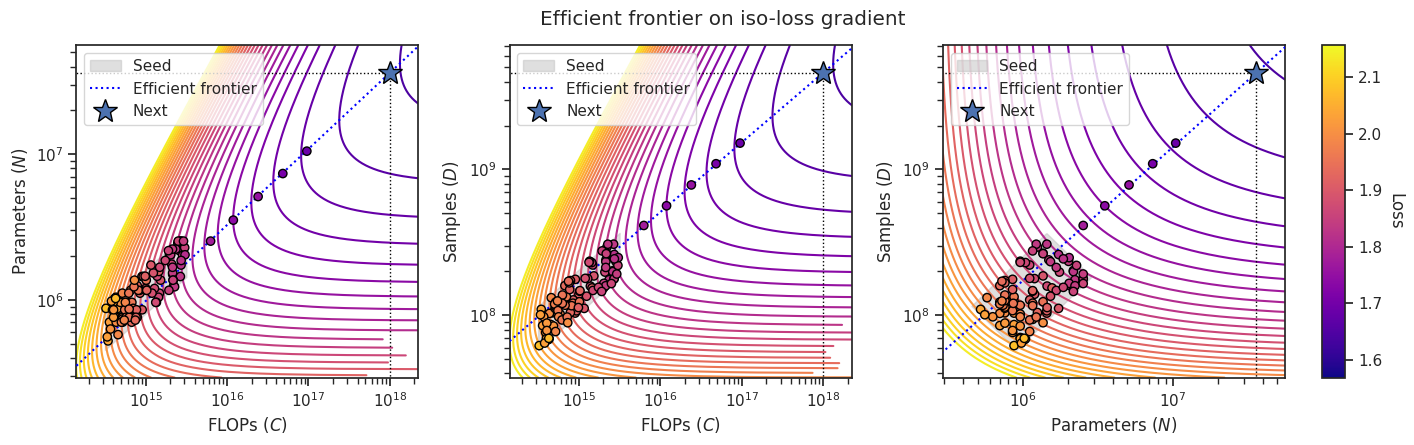

[16:42:25] INFO     Image saved to efficientcube/parametric_fit.png                               ]8;id=82442;file:///content/chinchilla/chinchilla/visualizer.py\visualizer.py]8;;\:]8;id=971104;file:///content/chinchilla/chinchilla/visualizer.py#153\153]8;;\

({'hidden_size': 1408, 'num_hidden_layers': 18},
 (36241920, 4594309307.4516058317))

In [ ]:
cc.fit()
(N, D), model_config = cc.scale(C=1e18)
# Or `cc.step(C=1e18)` to shortcut


model_config, (N, D)

You can access more precise values of the estimated parameters by calling `get_params` or `report`, whichever suits your need.

In [ ]:
cc.get_params()

{'E': 1.620406544125793,
 'A': 1116.7583712076722171,
 'B': 92697.423904473161286,
 'alpha': 0.6491512524478403,
 'beta': 0.7105431526502198}

[16:46:53] INFO     Estimated scaling law parameters:                                                   ]8;id=387179;file:///content/chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=657161;file:///content/chinchilla/chinchilla/core.py#680\680]8;;\

           INFO         - E: 1.620406544125793                                                          ]8;id=71573;file:///content/chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=700577;file:///content/chinchilla/chinchilla/core.py#682\682]8;;\

           INFO         - A: 1116.7583712076723                                                         ]8;id=614184;file:///content/chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=444546;file:///content/chinchilla/chinchilla/core.py#682\682]8;;\

           INFO         - B: 92697.42390447317                                                          ]8;id=14086;file:///content/chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=783121;file:///content/chinchilla/chinchilla/core.py#682\682]8;;\

           INFO         - alpha: 0.6491512524478403                                                     ]8;id=429286;file:///content/chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=847319;file:///content/chinchilla/chinchilla/core.py#682\682]8;;\

           INFO         - beta: 0.7105431526502198                                                      ]8;id=994516;file:///content/chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=152029;file:///content/chinchilla/chinchilla/core.py#682\682]8;;\

           INFO     Goodness of fit:                                                                    ]8;id=175626;file:///content/chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=262800;file:///content/chinchilla/chinchilla/core.py#684\684]8;;\

           INFO         - `asymmetric_mae`: 0.01501832                                                  ]8;id=75227;file:///content/chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=770618;file:///content/chinchilla/chinchilla/core.py#692\692]8;;\

           INFO     Landscape visualization:                                                            ]8;id=543548;file:///content/chinchilla/chinchilla/core.py\core.py]8;;\:]8;id=514032;file:///content/chinchilla/chinchilla/core.py#694\694]8;;\

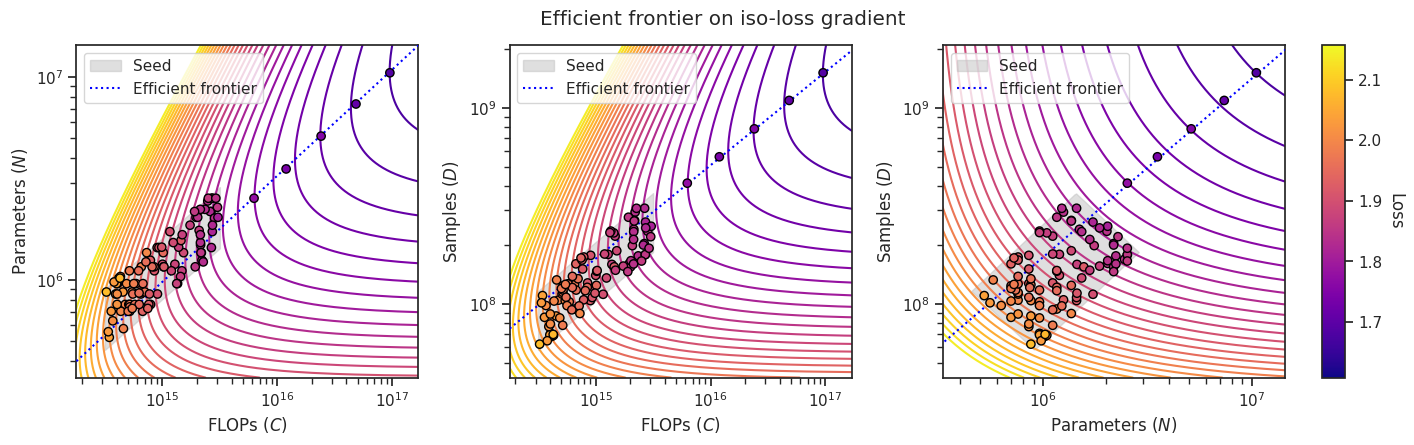

[16:46:55] INFO     Image saved to efficientcube/parametric_fit.png                               ]8;id=228969;file:///content/chinchilla/chinchilla/visualizer.py\visualizer.py]8;;\:]8;id=725488;file:///content/chinchilla/chinchilla/visualizer.py#153\153]8;;\

In [ ]:
cc.report()

We got to estimate the scaling law parameters.
The balance between `cc.alpha` and `cc.beta` should confirm the general scaling law tendency that we should scale parameters and data roughly in tandem.

## Use it to solve the Rubik's Cube

Let us actually use the compute-optimal to solve a few instances of Rubik's Cube. Again, we use `alphacube`.

In [ ]:
alphacube._solver.model = model

In [ ]:
alphacube.solve(
    "F2 D' L2 B2",
    allow_wide=False,
    beam_width=1,  # Greedy search
)

{'solutions': ['B2 L2 D F2'], 'num_nodes': 4, 'time': 0.07007538199832197}

In [ ]:
alphacube.solve(
    "D U F2 L2 U' B2 F2 D L2 U R' F' D R' F' U L D' F' D R2",
    allow_wide=False,
    beam_width=2**10,  # beam search
)

{'solutions': ["D' F' R' U' F' D' F' L' R' D' L B2 R B2 R B2 R2 F2 R2 U2 L2 F2 D' U' R2 U D",
  "D' F' R' U' F' D' F' L' R' D' R D2 R D2 R' L2 F2 U2 D2 L R U' D L2 U D' B2"],
 'num_nodes': 25888,
 'time': 0.42404056699888315}

Here, note that even though the compute-optimal large model is very accurate in terms of predicting optimal moves, it is practically very slow at expanding nodes with repetitive forward computations.
Which means, depending on devices, a smaller model trained with more data might be better off in terms of the accuracy-latency trade-off.

<!-- That's also where `chinchilla` might be useful
-- See [another notebook](https://github.com/kyo-takano/chinchilla/tree/master/examples/nn-for-search.ipynb) about ***training a compute-optimal model for search***, -->